### Import libraries

In [31]:
import os
import sys
import cv2
import json
import math 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from datasets import load_dataset 
from pycocotools.coco import COCO
from PIL import Image
from huggingface_hub import hf_hub_download

sys.path.append(os.path.abspath("../segment-anything-2"))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(),"..")))

### Load data:

In [2]:
from src.preprocess_data import load_and_split_dataset

In [3]:
HF_REPO_NAME = "peaceAsh/fashion_sam_dataset_v2"
COCO_DATASET = "peaceAsh/fashion_seg_coco_dataset"
JSON_FILE = "result.json"

In [4]:
fashion_ds = load_and_split_dataset(HF_REPO_NAME)

In [5]:
fashion_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'mask', 'filename'],
        num_rows: 13
    })
    validation: Dataset({
        features: ['image', 'mask', 'filename'],
        num_rows: 1
    })
    test: Dataset({
        features: ['image', 'mask', 'filename'],
        num_rows: 2
    })
})

In [6]:
coco_path = hf_hub_download(
    repo_id=COCO_DATASET,
    filename=JSON_FILE,
    repo_type="dataset" 
)

coco = COCO(coco_path)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [7]:
coco_imgs = coco.loadImgs(coco.getImgIds())
filename_to_ids = {img['file_name'] : img['id'] for img in coco_imgs}

In [8]:
def create_instance_list(dataset,coco,filename_to_ids):
    instance_list = []
    for i in tqdm(range(len(dataset))):
        item = dataset[i]
        base_filename = item['filename']
        coco_filename = base_filename.split('/')[-1]
        img_id = filename_to_ids[coco_filename]
        if img_id is not None:
            anns_ids = coco.getAnnIds(imgIds=img_id)
            anns = coco.loadAnns(anns_ids)
            for ann in anns:
                instance_list.append({
                    "dataset_idx":i,
                    "annotation":ann
                })
    return instance_list



train_instances = create_instance_list(fashion_ds['train'],coco,filename_to_ids)
val_instances = create_instance_list(fashion_ds['validation'],coco,filename_to_ids)

print(f"Number of images:{len(fashion_ds['train'])}")
print(f"Total training instances:{len(train_instances)}")
print(f"Number of images:{len(fashion_ds['validation'])}")
print(f"Total validation instances:{len(val_instances)}")

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Number of images:13
Total training instances:37
Number of images:1
Total validation instances:4


In [9]:
class FashionSAMDataset(Dataset):
    def __init__(self, dataset, instance_list, coco_api, image_size=1024, num_pts_per_instance=3):
        self.dataset = dataset
        self.instance_list = instance_list
        self.coco_api = coco_api
        self.image_size = int(image_size)
        self.num_pts_per_instance = int(num_pts_per_instance)

    def __len__(self):
        return len(self.instance_list)

    def _compute_scale_and_pad(self, width, height):
        target = self.image_size
        scale = target / max(width, height)
        new_w = int(round(width * scale))
        new_h = int(round(height * scale))
        pad_left = (target - new_w) // 2
        pad_top = (target - new_h) // 2
        return scale, new_w, new_h, pad_left, pad_top

    def _resize_and_pad_image(self, image):
        w, h = image.size
        scale, new_w, new_h, pad_left, pad_top = self._compute_scale_and_pad(w, h)
        resized = image.resize((new_w, new_h), Image.Resampling.LANCZOS)
        canvas = Image.new("RGB", (self.image_size, self.image_size), (0, 0, 0))
        canvas.paste(resized, (pad_left, pad_top))
        arr = np.array(canvas, dtype=np.uint8)   # H x W x 3
        return arr, (scale, pad_left, pad_top)

    def _resize_and_pad_mask(self, mask, scale, pad_left, pad_top):
        h, w = mask.shape
        new_w = int(round(w * scale))
        new_h = int(round(h * scale))
        if new_w == 0 or new_h == 0:
            padded = np.zeros((self.image_size, self.image_size), dtype=np.uint8)
            return padded
        resized = cv2.resize(mask.astype(np.uint8), (new_w, new_h), interpolation=cv2.INTER_NEAREST)
        padded = np.zeros((self.image_size, self.image_size), dtype=np.uint8)
        padded[pad_top:pad_top + new_h, pad_left:pad_left + new_w] = resized
        return padded

    def _sample_points_from_mask(self, mask, num_points):
        h, w = mask.shape
        kernel = np.ones((3, 3), np.uint8)
        eroded = cv2.erode(mask.astype(np.uint8), kernel, iterations=1)
        coords = np.argwhere(eroded > 0)  # rows=y, cols=x
        if coords.shape[0] == 0:
            coords = np.argwhere(mask > 0)

        if coords.shape[0] == 0:
            return np.empty((0, 2), dtype=np.float32)

        num_available = coords.shape[0]
        k = min(num_points, num_available)
        chosen_idx = np.random.choice(num_available, k, replace=False)
        chosen = coords[chosen_idx]  # (y, x)
        xy = chosen[:, ::-1].astype(np.float32)
        return xy

    def __getitem__(self, idx):
        inst = self.instance_list[idx]
        dataset_idx = inst['dataset_idx']
        annotation = inst['annotation']

        image_pil = self.dataset[dataset_idx]['image'].convert("RGB")
        mask_orig = self.coco_api.annToMask(annotation).astype(np.uint8)  # H x W

        points_orig = self._sample_points_from_mask(mask_orig, self.num_pts_per_instance)  # Nx2 (x,y)

        image_arr, (scale, pad_left, pad_top) = self._resize_and_pad_image(image_pil)
        mask_padded = self._resize_and_pad_mask(mask_orig, scale, pad_left, pad_top)

        if points_orig.shape[0] > 0:
            points_resized = points_orig * scale
            points_resized[:, 0] += pad_left   # x
            points_resized[:, 1] += pad_top    # y
            points_tensor = torch.from_numpy(points_resized).float()  # (N,2)
            labels_tensor = torch.ones(points_tensor.shape[0], dtype=torch.int64)  # foreground=1
        else:
            points_tensor = torch.empty((0, 2), dtype=torch.float32)
            labels_tensor = torch.empty((0,), dtype=torch.int64)

        image_tensor = torch.from_numpy(image_arr).permute(2, 0, 1).float()  # (3,H,W)
        mask_tensor = torch.from_numpy(mask_padded).unsqueeze(0).float()     # (1,H,W)

        return {
            "image": image_tensor,           # (3,H,W)
            "mask": mask_tensor,             # 1,H,W) 0/1
            "points": points_tensor,         # (N,2) 
            "point_labels": labels_tensor,   # (N,) 
        }


In [10]:
def sam_collate_fn(batch):
    images = torch.stack([item['image'] for item in batch])
    masks = torch.stack([item['mask'] for item in batch])
    points = [item['points'] for item in batch]
    point_labels = [item['point_labels'] for item in batch]
    
    return {
        'image': images,
        'mask': masks,
        'points': points,
        'point_labels': point_labels
    }

In [12]:
train_dataset = FashionSAMDataset(
    dataset=fashion_ds['train'],
    instance_list=train_instances,
    coco_api=coco
)

val_dataset = FashionSAMDataset(   
    dataset=fashion_ds['validation'],
    instance_list=val_instances,
    coco_api=coco
)


In [13]:
BATCH_SIZE = 2

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=sam_collate_fn,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=sam_collate_fn,
)

In [60]:
first_batch = next(iter(train_dataloader))
print(f"Image batch shape:{first_batch['image'].shape} dtype:{first_batch['image'].dtype}")
print(f"Mask batch shape:{first_batch['mask'].shape} dtype:{first_batch['mask'].dtype}")
print(f"Points batch length:{len(first_batch['points'])} dtype:{first_batch['points'][0].dtype}")
print(f"Points:{first_batch['points']}")
print(f"Point labels batch length:{len(first_batch['point_labels'])} dtype:{first_batch['point_labels'][0].dtype}")

Image batch shape:torch.Size([2, 3, 1024, 1024]) dtype:torch.float32
Mask batch shape:torch.Size([2, 1, 1024, 1024]) dtype:torch.float32
Points batch length:2 dtype:torch.float32
Points:[tensor([[614., 793.],
        [513., 605.],
        [579., 728.]]), tensor([[615., 359.],
        [601., 366.],
        [594., 341.]])]
Point labels batch length:2 dtype:torch.int64


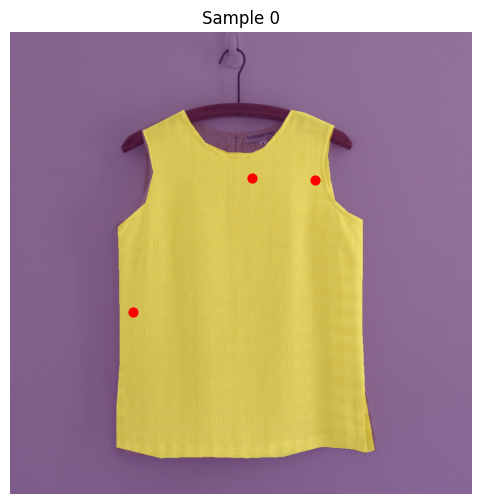

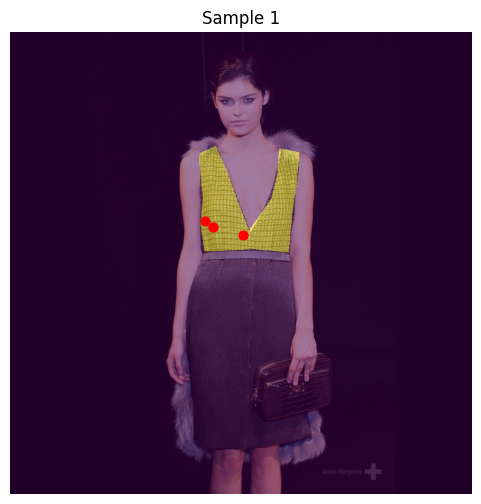

In [15]:
def viz_batch(batch):

    images = batch['image']  # (B, 3, H, W)
    masks = batch['mask']    # (B, 1, H, W)
    points = batch['points'] # list of (N, 1, 2)
    point_labels = batch['point_labels'] # list of (N,)

    B = images.shape[0]

    for i in range(B):
        img = images[i].permute(1, 2, 0).cpu().numpy().astype('uint8')
        mask = masks[i][0].cpu().numpy()
        pts = points[i].squeeze(1).cpu().numpy()  # (N, 2)
        
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.imshow(mask, alpha=0.5)
        if pts.shape[0] > 0:
            plt.scatter(pts[:, 0], pts[:, 1], c='red', s=40, marker='o')
        plt.title(f"Sample {i}")
        plt.axis('off')
        plt.show()

batch = next(iter(train_dataloader))
viz_batch(batch)

### Load model configs and checkpoints

In [25]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam2_checkpoint = "/home/FashionSeg/models/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

sam2_model = build_sam2(model_cfg,sam2_checkpoint,device=device)
predictor = SAM2ImagePredictor(sam2_model)

In [74]:
BATCH_SIZE = 2
ACCUMULATION_STEPS = 4
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-4
EPOCHS = 20
CHECKPOINT_INTERVAL = 5
EVAL_INTERVAL = 2

EXP_NAME = "fashion_sam2_finetune_v0"
CHECKPOINT_DIR = f"../checkpoints/{EXP_NAME}"
LOGS_DIR =  f"../logs/{EXP_NAME}"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

writer = SummaryWriter(LOGS_DIR)
print(f"Starting experiment:{EXP_NAME}\n Logs  saved in :{LOGS_DIR}")

Starting experiment:fashion_sam2_finetune_v0
 Logs  saved in :../logs/fashion_sam2_finetune_v0


In [28]:
for name, param in sam2_model.named_parameters():
    if "prompt_encoder" in name or "mask_decoder" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
predictor.model.sam_mask_decoder.train(True)
predictor.model.sam_prompt_encoder.train(True)
predictor.model.image_encoder.train(False)

### Loss functions and training the model:

In [66]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F

In [67]:
def dice_loss(inputs, targets):
    inputs = inputs.sigmoid().flatten(1)
    targets = targets.flatten(1)
    numerator = 2 * (inputs * targets).sum(-1)
    denominator = inputs.sum(-1) + targets.sum(-1)
    loss = 1 - (numerator + 1) / (denominator + 1)
    return loss.mean()

def sigmoid_focal_loss(inputs, targets, alpha: float = 0.25, gamma: float = 2):
    prob = inputs.sigmoid()
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = prob * targets + (1 - prob) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)
    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss
    return loss.mean()

def total_loss_fn(pred_masks, gt_masks, dice_weight=0.8, focal_weight=0.2):
    """Combined Dice and Focal loss."""
    dice = dice_loss(pred_masks, gt_masks)
    focal = sigmoid_focal_loss(pred_masks, gt_masks)
    total_loss = (dice_weight * dice) + (focal_weight * focal)
    return total_loss, {"dice": dice, "focal": focal}

In [70]:
optimizer = AdamW(predictor.model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
scaler = torch.amp.GradScaler('cuda')

In [71]:
def forward(predictor,images,input_point,input_label):
    batch_size = images.shape[0]
    image_list = []
    
    for i in range(batch_size):
        # Convert from (C, H, W) tensor to (H, W, C) numpy array
        img = images[i].permute(1, 2, 0).cpu().numpy().astype(np.uint8)
        image_list.append(img)

    input_points =  np.array(input_point, dtype=np.float32)
    input_labels =  np.array(input_label, dtype=np.float32)
    
    predictor.set_image_batch(image_list)
    mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_points, input_labels, box=None, mask_logits=None, normalize_coords=True)      # 有提示
    sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(points=(unnorm_coords, labels), boxes=None, masks=None)
    high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
    low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
        image_embeddings=predictor._features["image_embed"],
        image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
        repeat_image=False,
        high_res_features=high_res_features
    )
    prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])  
    prd_masks_logits = prd_masks[:, 0]
    return prd_masks, prd_scores, torch.sigmoid(prd_masks_logits)

In [72]:
def train_epochs(predictor,train_dataloader,epoch,optimizer,scaler,scheduler,writer,accumulation_steps):
    step = len(train_dataloader) * epoch
    progress_bar = tqdm(train_dataloader, colour='green')

    for batch_idx, batch in enumerate(progress_bar):
        image = batch['image']
        mask = batch['mask']
        input_point = batch['points']
        input_label = batch['point_labels']

        gt_mask = mask.float().to(device)
        step += 1
        with torch.amp.autocast('cuda'): 
            prd_masks, prd_scores, prd_mask = forward(predictor, image, input_point, input_label)
            loss , losses = total_loss_fn(prd_masks, gt_mask)
            
        loss = loss / accumulation_steps
        predictor.model.zero_grad()
        scaler.scale(loss).backward()
        
        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        progress_bar.set_postfix({
                'Loss': f'{loss.item() * accumulation_steps:.3f}',
                'Dice Loss': f'{losses["dice"].item():.2f}',
                'Focal Loss': f'{losses["focal"].item():.2f}',
            })

        writer.add_scalar('train/total loss', loss.item() * accumulation_steps, step)
        writer.add_scalar('lr', optimizer.param_groups[0]['lr'], step)
        for key, value in losses.items():
            writer.add_scalar(f'train/{key}loss', value.item(), step)
            
    scheduler.step()  
    
def validate(predictor,val_dataloader,epoch,writer):
    predictor.model.sam_mask_decoder.train(False)
    total_val_loss = 0.0
    for batch_idx, batch in enumerate(tqdm(val_dataloader, colour='blue')):
            image = batch['image']
            mask = batch['mask']
            input_point = batch['points']
            input_label = batch['point_labels']

            gt_mask = mask.float().to(device)
            prd_masks, prd_scores, prd_mask = forward(predictor, image, input_point, input_label)
            val_loss, val_losses = total_loss_fn(prd_masks,gt_mask)
            total_val_loss += val_loss.item()
    total_val_loss /= len(val_dataloader)
    predictor.model.sam_mask_decoder.train(True)
    print(f"Epoch {epoch + 1}, Val Loss: {total_val_loss:.3f}")
    writer.add_scalar('val/total_loss', total_val_loss, epoch + 1)

In [75]:
for epoch in range(EPOCHS):
        train_epochs(predictor, train_dataloader, epoch, optimizer, scaler, scheduler, writer, ACCUMULATION_STEPS)
        if (epoch + 1) % EVAL_INTERVAL == 0:
                validate(predictor, val_dataloader, epoch, writer)
        if (epoch + 1) % CHECKPOINT_INTERVAL == 0:
                torch.save(predictor.model.state_dict(), f"{CHECKPOINT_DIR}/model_epoch_{epoch + 1}.pt")
writer.close()

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2, Val Loss: 0.237


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4, Val Loss: 0.196


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6, Val Loss: 0.212


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8, Val Loss: 0.225


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10, Val Loss: 0.207


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12, Val Loss: 0.198


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14, Val Loss: 0.213


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16, Val Loss: 0.209


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18, Val Loss: 0.282


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20, Val Loss: 0.210
